# Building Model LSTM+CRF
### By **Néstor Suat** in 2020

**Descripción:** Generando un modelo ML para la tarea de NER en tweets de accidentes para las etiquetas `loc` y `time` usando el estandar BIO.

**Input:**
* TSV con dataset etiquetado con BIO

**Output:**
* Model

**Tomado de**: 
* https://www.depends-on-the-definition.com/sequence-tagging-lstm-crf/ 
* https://github.com/tensorflow/addons/issues/1769 
* https://github.com/howl-anderson/tf_crf_layer
***

### Importando librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use("ggplot")

from gensim.models.doc2vec import Doc2Vec
import spacy

import fasttext
import fasttext.util

### Source code

La clase `StenteceGetter` es una clase generica en muchos proyectos de NER, permite tomar el dataset y prepararlo en una lista python para trabajar por oraciones.

In [3]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            #s = self.grouped["Sentence: {}".format(self.n_sent)]
            s = self.grouped[self.n_sent]
            self.n_sent += 1
            return s
        except:
            return None

### Importando dataset anotado

El archivo `ner-crf-training-data.tsv` fue construido anteriormente transformando el formato de anotación de Standoff a BIO.

In [4]:
file = 'ner-crf-training-data.tsv'
dir_ = "../../../data/v1/NER/train/"
train = pd.read_csv(dir_+file, delimiter = "\t", quoting = 3, names=['Sentence #','Word','POS','Tag'])

In [5]:
file = 'ner-crf-test-data.tsv'
dir_ = "../../../data/v1/NER/test/"
test = pd.read_csv(dir_+file, delimiter = "\t", quoting = 3, names=['Sentence #','Word','POS','Tag'])

#### **Preparando el dataset**

Se construye un corpus de todas las palabras presentes en los tweets, se agrega un token esepcial para rellenar llamado ENDPAD, finalmente se calcula el tamaño del corpus de palabras. Esto mismo se hace para las etiquetas, aunque en este caso es más fácil porque son 5: `b-loc`, `i-loc`, `b-time`, `i-time` y `o`.

In [6]:
#tags = list(set(data["Tag"].values))
tags = ['B-loc', 'I-loc', 'B-time', 'I-time', 'O']
n_tags = len(tags); n_tags

5

Se toman los datos y se construye el arreglo de las oraciones a trabajar

### Trainset

In [7]:
getter = SentenceGetter(train)
train_sentences = getter.sentences

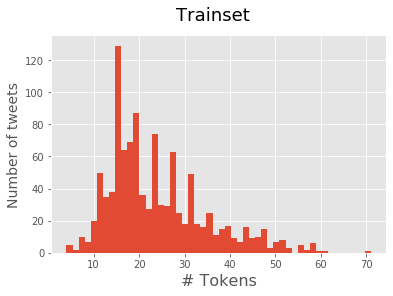

In [45]:
fig = plt.figure()
#plt.plot(data)
fig.suptitle('Trainset', fontsize=18)
plt.xlabel('# Tokens', fontsize=16)
plt.ylabel('Number of tweets', fontsize=14)

plt.hist([len(s) for s in train_sentences], bins=50)
plt.show()

fig.savefig('test.jpg',dpi=300)

En la gráfica anterior se puede observar el tamaño máximo de los tweets. Para Keras se necesita como entrada una longitud fija de secuencias, por esta razón se elije 70 como un valor máximo.

### Testset

In [9]:
getter = SentenceGetter(test)
test_sentences = getter.sentences

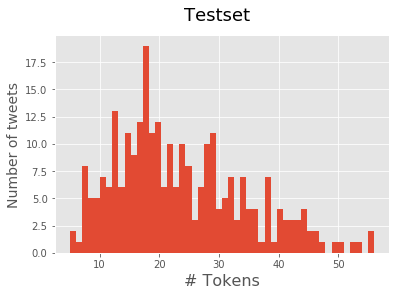

In [46]:
fig = plt.figure()
#plt.plot(data)
fig.suptitle('Testset', fontsize=18)
plt.xlabel('# Tokens', fontsize=16)
plt.ylabel('Number of tweets', fontsize=14)

plt.hist([len(s) for s in test_sentences], bins=50)
plt.show()

fig.savefig('test.jpg',dpi=300)

In [11]:
#Aquí NO empezamos desde 0, ese id lo reservamos para el mask_zero de la capa Embedding
max_len = 70
#word2idx = {w: i + 1 for i, w in enumerate(words)}
tag2idx = {t: i for i, t in enumerate(tags)}

Finalmente se crea un dicccionario (key:value) del corpus de palabras y se le asigna un id.

In [12]:
tag2idx['B-time']

2

## Tokenize and prepare the sentences

Construyendo una representación vectorial numérica. Ahora se mapea las oraciones en una secuencia de números y si el tweet es más pequeño que el `max_len` se agrega una secuencia de pads.

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

Agregando PAD para rellenar las oraciones cortas que cummplan con el tamaño de 70 tokens

In [14]:
#zeros = np.zeros(200,dtype=np.float32)
#X_train = [[word2idx[w[0]] for w in s] for s in train_sentences]
#X_train = pad_sequences(maxlen=max_len, dtype='float32', sequences=X_train, padding="post", value=zeros) # (1072,70,200)
#value = 0, significa que la mask para endpad será 0

y_train = [[tag2idx[w[2]] for w in s] for s in train_sentences]
y_train = pad_sequences(maxlen=max_len, sequences=y_train, padding="post", value=tag2idx["O"])

#print(X_train[1])
print(y_train[1])

[4 4 4 4 4 4 4 0 1 1 1 4 4 4 4 4 0 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


In [15]:
#zeros = np.zeros(200,dtype=np.float32)
#X_test = [[word2idx[w[0]] if w[0] in words else word2idx['UNDEFINED'] for w in s] for s in test_sentences]
#X_test = pad_sequences(maxlen=max_len, dtype='float32', sequences=X_test, padding="post", value=zeros)

y_test = [[tag2idx[w[2]] for w in s] for s in test_sentences]
y_test = pad_sequences(maxlen=max_len, sequences=y_test, padding="post", value=tag2idx["O"])

#print(X_test[1])
print(y_test[1])

[4 4 4 4 4 2 3 3 4 4 4 4 4 4 0 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 0 1 1 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4]


**Para entrenar la red, necesitamos tambien cambiar 'label' a categorical.**

In [16]:
y_train = [to_categorical(i, num_classes=n_tags) for i in y_train]
y_test = [to_categorical(i, num_classes=n_tags) for i in y_test]

## Train and Test set

In [17]:
_dir = "../../../data/v1/NER/numpy/"
X_train = np.load(_dir+'X_train-ft-300.npy')
X_test = np.load(_dir+'X_test-ft-300.npy')

In [18]:
print("Train:",X_train.shape, len(y_train))
print("Test:",X_test.shape, len(y_test))

Train: (1072, 70, 300) 1072
Test: (268, 70, 300) 268


## Build and fit the LSTM model

In [19]:
from tensorflow.keras.models import Model
from tensorflow.keras import Input, Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from tensorflow import keras
#import tensorflow_addons as tfa
import tensorflow as tf

#from keras_contrib.layers import CRF
#from tf2crf import CRF

In [20]:
from crf import CRF

In [48]:
"""
from sklearn_crfsuite import metrics

acc = [] 
r_micro = []
r_macro = []
r_weighted = []
p_micro = []
p_macro = []
p_weighted = []
f1_micro = []
f1_macro = []
f1_weighted = []
loss_val = []
acc_val = []
for i in range(25):
    print(i)
"""
dropout = 0.5
input_shape=(70,300)

callback = tf.keras.callbacks.EarlyStopping(monitor='val_viterbi_accuracy', patience=10, mode='max', restore_best_weights=True)


model = Sequential()
# n_words + 1, es por la max_zero = 0
#model.add(Embedding(input_dim=n_words+1, output_dim=20, input_length=max_len, mask_zero=True)) # 20-dim embedding
#input_layer = Input(shape=input_shape)
model.add(Input(shape=input_shape))
model.add(Bidirectional(LSTM(units=100, return_sequences=True, dropout=dropout, recurrent_dropout=dropout, kernel_initializer='he_uniform')))
model.add(TimeDistributed(Dense(5, activation="relu")))
crf = CRF(n_tags)
model.add(crf)

optimizer = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999)
model.compile(optimizer=optimizer, loss=crf.loss, metrics=[crf.accuracy])
#model.compile(optimizer='adam', loss=crf.loss, metrics=[crf.accuracy])
#model.compile(optimizer='adam', loss=crf.loss_function, metrics=[crf.accuracy])
#model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_accuracy])
#model.compile(optimizer="rmsprop", loss=crf.loss, metrics=[crf.accuracy])

history = model.fit(X_train, np.array(y_train), batch_size=16, epochs=40, validation_split=0.2, verbose=1, callbacks=[callback])
"""
    test_pred = model.predict(X_test, verbose=0)

    pred_labels = pred2label(test_pred)
    test_labels = pred2label(y_test)
    
    metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)
    
    metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels)
    metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels)

    acc.append(metrics.flat_accuracy_score(test_labels, pred_labels))
  
    r_micro.append(metrics.flat_recall_score(test_labels, pred_labels, average='micro', labels=labels))
    r_macro.append(metrics.flat_recall_score(test_labels, pred_labels, average='macro', labels=labels))
    r_weighted.append(metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels))
    
    p_micro.append(metrics.flat_precision_score(test_labels, pred_labels, average='micro', labels=labels))
    p_macro.append(metrics.flat_precision_score(test_labels, pred_labels, average='macro', labels=labels))
    p_weighted.append(metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels))
    
    f1_micro.append(metrics.flat_f1_score(test_labels, pred_labels, average='micro', labels=labels))
    f1_macro.append(metrics.flat_f1_score(test_labels, pred_labels, average='macro', labels=labels))
    f1_weighted.append(metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels))

    loss_val.append(history.history['val_loss'][::-1][0])
    acc_val.append(history.history['val_viterbi_accuracy'][::-1][0])
"""

Epoch 1/40
54/54 [==============================] - 11s 212ms/step - loss: 46.1694 - viterbi_accuracy: 0.6933 - val_loss: 58.5834 - val_viterbi_accuracy: 0.9286
Epoch 2/40
54/54 [==============================] - 9s 173ms/step - loss: 12.6591 - viterbi_accuracy: 0.9440 - val_loss: 56.5785 - val_viterbi_accuracy: 0.9421
Epoch 3/40
54/54 [==============================] - 10s 181ms/step - loss: 8.9759 - viterbi_accuracy: 0.9589 - val_loss: 55.8188 - val_viterbi_accuracy: 0.9504
Epoch 4/40
54/54 [==============================] - 10s 179ms/step - loss: 7.6940 - viterbi_accuracy: 0.9659 - val_loss: 55.3482 - val_viterbi_accuracy: 0.9552
Epoch 5/40
54/54 [==============================] - 11s 199ms/step - loss: 6.8772 - viterbi_accuracy: 0.9707 - val_loss: 54.7828 - val_viterbi_accuracy: 0.9584
Epoch 6/40
54/54 [==============================] - 11s 197ms/step - loss: 6.2694 - viterbi_accuracy: 0.9735 - val_loss: 54.5818 - val_viterbi_accuracy: 0.9599
Epoch 7/40
54/54 [=====================

"\n    test_pred = model.predict(X_test, verbose=0)\n\n    pred_labels = pred2label(test_pred)\n    test_labels = pred2label(y_test)\n    \n    metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)\n    \n    metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels)\n    metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels)\n\n    acc.append(metrics.flat_accuracy_score(test_labels, pred_labels))\n  \n    r_micro.append(metrics.flat_recall_score(test_labels, pred_labels, average='micro', labels=labels))\n    r_macro.append(metrics.flat_recall_score(test_labels, pred_labels, average='macro', labels=labels))\n    r_weighted.append(metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels))\n    \n    p_micro.append(metrics.flat_precision_score(test_labels, pred_labels, average='micro', labels=labels))\n    p_macro.append(metrics.flat_precision_score(test_labels, pred_l

In [22]:
model.evaluate(X_test,np.array(y_test))

9/9 [==============================] - 0s 48ms/step - loss: 34.5785 - viterbi_accuracy: 0.9691


[34.57848358154297, 0.969146728515625]

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 70, 200)           320800    
_________________________________________________________________
time_distributed (TimeDistri (None, 70, 5)             1005      
_________________________________________________________________
crf (CRF)                    (None, 70, 5)             25        
Total params: 321,830
Trainable params: 321,830
Non-trainable params: 0
_________________________________________________________________


dict_keys(['loss', 'viterbi_accuracy', 'val_loss', 'val_viterbi_accuracy'])


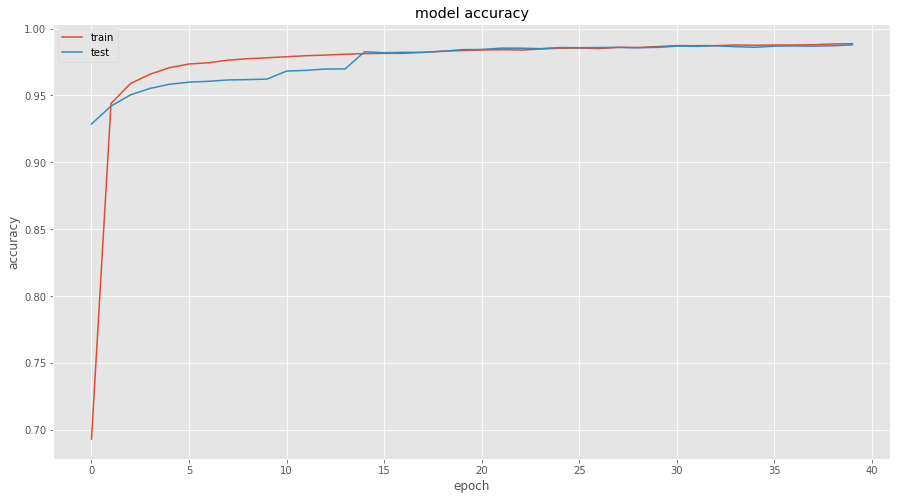

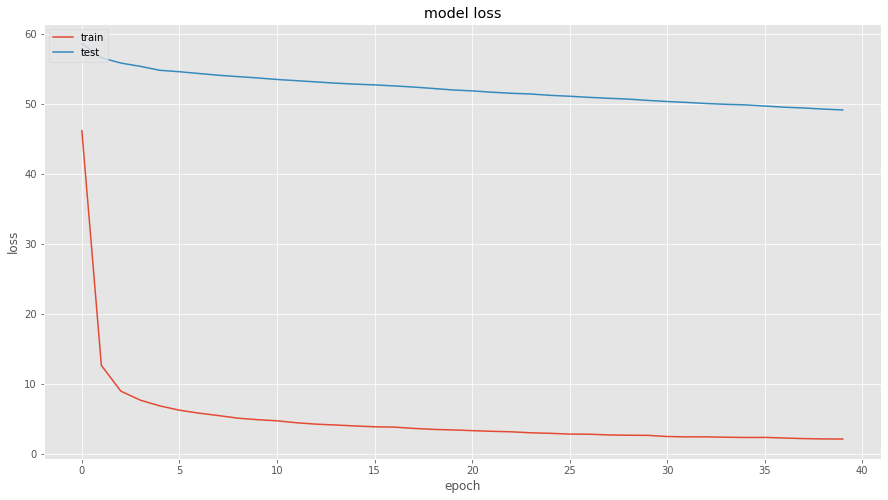

In [49]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.figure(figsize=(15, 8))
plt.plot(history.history['viterbi_accuracy'])
plt.plot(history.history['val_viterbi_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.figure(figsize=(15, 8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Evaluate

In [25]:
from seqeval.metrics import precision_score, recall_score, f1_score, classification_report

In [50]:
test_pred = model.predict(X_test, verbose=1)

9/9 [==============================] - 0s 39ms/step


In [51]:
idx2tag = {i: w for w, i in tag2idx.items()}

"""
def pred2label(pred,is_test):
    out = []
    for pred_i in pred:        
        out_i = []
        for p in pred_i:   
            if is_test:
                p_i = np.argmax(p)            
            else:
                p_i = int(p)            
            out_i.append(idx2tag[p_i].replace("PAD", "O"))            
        out.append(out_i)        
    return out
#pred_labels = pred2label(test_pred,False)
#test_labels = pred2label(y_test,True)
"""
def pred2label(pred):
    out = []
    for pred_i in pred:        
        out_i = []
        for p in pred_i:               
            p_i = np.argmax(p)                                        
            out_i.append(idx2tag[p_i].replace("PAD", "O"))            
        out.append(out_i)        
    return out

pred_labels = pred2label(test_pred)
test_labels = pred2label(y_test)

print("F1-score: {:.1%}".format(f1_score(test_labels, pred_labels)))
print(classification_report(test_labels, pred_labels))

F1-score: 71.1%
              precision    recall  f1-score   support

         loc       0.77      0.71      0.74       371
        time       0.45      0.39      0.42        33

   micro avg       0.74      0.68      0.71       404
   macro avg       0.61      0.55      0.58       404
weighted avg       0.74      0.68      0.71       404



In [52]:
from sklearn_crfsuite import metrics

labels = ['B-loc', 'I-loc', 'B-time', 'I-time']
# group B and I results
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    test_labels, pred_labels, labels=sorted_labels, digits=4
))
print("F1-score: {:.1%}".format(metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels)))

              precision    recall  f1-score   support

       B-loc     0.9071    0.7940    0.8468       369
       I-loc     0.9319    0.9194    0.9256       893
      B-time     0.5556    0.4545    0.5000        33
      I-time     0.9231    0.3636    0.5217        33

   micro avg     0.9172    0.8592    0.8872      1328
   macro avg     0.8294    0.6329    0.6985      1328
weighted avg     0.9154    0.8592    0.8831      1328

F1-score: 88.3%


In [31]:
print(metrics.flat_f1_score(test_labels, pred_labels, average='weighted', labels=labels))
print(metrics.flat_accuracy_score(test_labels, pred_labels))
print(metrics.flat_precision_score(test_labels, pred_labels, average='weighted', labels=labels))
print(metrics.flat_recall_score(test_labels, pred_labels, average='weighted', labels=labels))

0.8734610229824442
0.9866737739872068
0.9122902961996354
0.8403614457831325


In [53]:
i=1
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
np.argmax(y_test[i], axis=-1)
print("{:15} ({:5}): {}".format("Word", "True", "Pred"))
for w, true, pred in zip(test_sentences[i], np.argmax(y_test[i],axis=-1), p[0]):    
    print("{:15} ({:5}): {}".format(w[0], tags[true], tags[pred]))

Word            (True ): Pred
movilidad       (O    ): O
bogota          (O    ): O
acueducto       (O    ): O
trancon         (O    ): O
accidente       (O    ): O
llevó           (B-time): O
3               (I-time): O
horas           (I-time): O
en              (O    ): O
el              (O    ): O
carro           (O    ): O
bajando         (O    ): O
de              (O    ): O
la              (O    ): O
calera          (B-loc): O
y               (O    ): O
muchos          (O    ): O
Buses           (O    ): O
escolares       (O    ): O
con             (O    ): O
niños           (O    ): O
pequeños        (O    ): O
de              (O    ): O
los             (O    ): O
colegios        (O    ): O
,               (O    ): O
nada            (O    ): O
que             (O    ): O
quitan          (O    ): O
el              (O    ): O
camión          (O    ): O
del             (O    ): O
acueducto       (O    ): O
que             (O    ): O
se              (O    ): O
accidentó       (O    

In [ ]:
TP = {}
TN = {}
FP = {}
FN = {}
for tag in tag2idx.keys():
    TP[tag] = 0
    TN[tag] = 0    
    FP[tag] = 0    
    FN[tag] = 0    

def accumulate_score_by_tag(gt, pred):
    """
    For each tag keep stats
    """
    if gt == pred:
        TP[gt] += 1
    elif gt != 'O' and pred == 'O':
        FN[gt] +=1
    elif gt == 'O' and pred != 'O':
        FP[gt] += 1
    else:
        TN[gt] += 1

In [ ]:
for i, sentence in enumerate(X_test):
    y_hat = np.argmax(test_pred[0], axis=-1)
    gt = np.argmax(y_test[0], axis=-1)
    for idx, (w,pred) in enumerate(zip(sentence,y_hat)):
        accumulate_score_by_tag(idx2tag[gt[idx]],tags[pred])


In [ ]:
for tag in tag2idx.keys():
    print(f'tag:{tag}')    
    print('\t TN:{:10}\tFP:{:10}'.format(TN[tag],FP[tag]))
    print('\t FN:{:10}\tTP:{:10}'.format(FN[tag],TP[tag]))    


### Evaluando con una muestra